# IS318 - Machine Learning

## TP1 - Linear regression

The goal of this TP is to experiment with linear regression and polynomial linear regression.

First, we will work **without** the use of external libraries (such as `scikit-learn`).

In [77]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error

# 1. Dataset

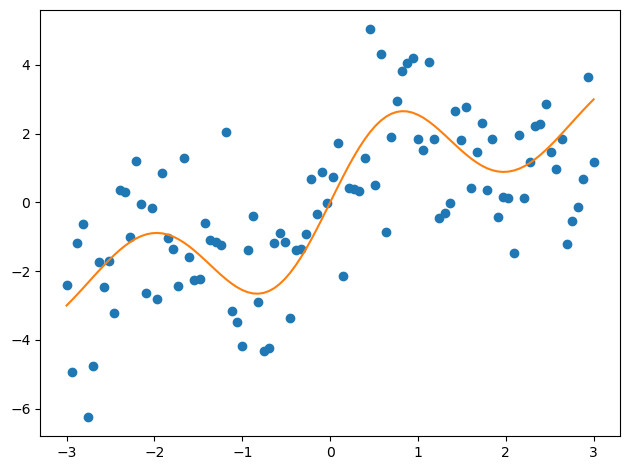

In [78]:
# Let us generate data points from a relatively complicated function
N = 100
alpha, sigma = 2., 3.
X = np.linspace(-3, 3, num=N)
y = X + (alpha * np.sin((2. * np.pi * X) / sigma) * np.exp(-(X ** 2) / (sigma ** 2)))

# Add some random noise
rng = np.random.default_rng(42)
y_noisy = y + rng.standard_normal(N) * 2.

# Show the data points
plt.plot(X, y_noisy, 'o')
plt.plot(X, y)
plt.tight_layout()

**(Question)** Shuffle and split the dataset into training (75%) and validation (25%) sets. Store the results into variables `X_train`, `y_train`, `X_valid`, `y_valid`.

*Hint:* you can use `rng.permutation` to generate a random permutation.

In [79]:
pairs = np.column_stack((X, y_noisy))

permuted = pairs[rng.permutation(pairs.shape[0])]

X_shuffled = permuted[:,0]
y_shuffled = permuted[:,1]

split = int(N * 0.75)

X_train, X_valid = X_shuffled[:split], X_shuffled[split:]
y_train, y_valid = y_shuffled[:split], y_shuffled[split:]

In [80]:
assert X_train.shape == (75,)
assert y_train.shape == (75,)
assert X_valid.shape == (25,)
assert y_valid.shape == (25,)
assert np.any(X_valid != X[75:]) # points should be shuffled

# 2. Linear regression in 1D

Recall the 1D linear regression model, where we search for parameters $w_0, w_1$ that will satisfy $y_i = w_0 + w_1 x_i$ (for all $i$ in the training set).

To simplify calculations, we usually set $\textbf{w} = [w_0, w_1]^T$ and $\textbf{x}_i = [1, x_i]^T$.

Then we have $y_i = \textbf{w}^T \textbf{x}_i $.

**(Question)** Add a column with ones to the points in `X_train` and `X_valid`. Store the result in new variables `X_train_ones` and `X_valid_ones`:

In [81]:
X_train_ones = np.c_[np.ones(len(X_train)), X_train]
X_valid_ones = np.c_[np.ones(len(X_valid)), X_valid]

**(Question)** Use normal equations to find the parameters that minimize the mean squared error on the training set.

In [82]:
first = np.linalg.inv(np.dot(X_train_ones.T, X_train_ones)) # (X^T*X)^-1
second = np.dot(first, X_train_ones.T)                      # (X^T*X)^-1 * X^T

In [83]:
w = np.dot(second, y_train) # (X^T*X)^-1 * X^T * y
w

array([-0.03550166,  0.68680383])

In [84]:
assert w.shape == (2,)

**(Question)** Is it always possible to apply this solution? Can you think of example situations where it might not work?

* If the matrix $X^TX$ is singular (non-invertible). This can happen if features are linearly dependent (multicollinearity) or if the number of features is higher than the number of samples (overparametrization) (not often).

* Another problem can be the computational resources needed to compute the inverse for large datasets; because the computation of the inverse requires lots of operations.

**(Question)** Plot the fitted line on top of the data points. Explain the result. (complete the code and comment in the cell below)

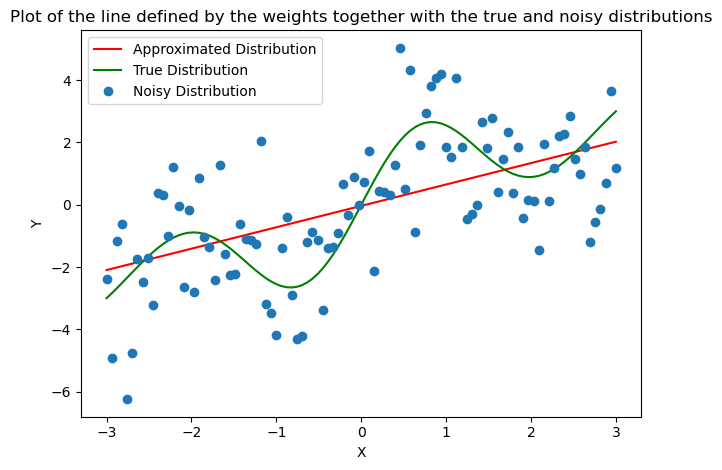

In [85]:
fit = w[1] * X + w[0]

# Show the data points
plt.plot(X, fit, 'r', label=r'Approximated Distribution')
plt.plot(X, y, 'g', label=r'True Distribution')
plt.plot(X, y_noisy, 'o', label=r'Noisy Distribution')
plt.xlabel(r'X')
plt.ylabel(r'Y')
plt.title(r'Plot of the line defined by the weights together with the true and noisy distributions')
plt.legend()
plt.tight_layout()

This result is quiet satisfiable because we see that it minimizes the error with the true distribution for each point (the estimated line always stays between the extrema). But we see that the approximation still has large difference for the different extrema (which is normal assuming that we approximate a function defined in terms of sinus and exponentials with a polynomial of degree $1$).

**(Question)** Plot the loss function landscape. What can you conclude from this visualization? (complete the code and comment in the cell below)

*Hint: the loss landscape can be represented by a 2D map (for example of size 100x100) where in each coordinate $(w_0, w_1)$ the value is mean squared error for these parameters. You can use `plt.contourf` to visualize the result.*

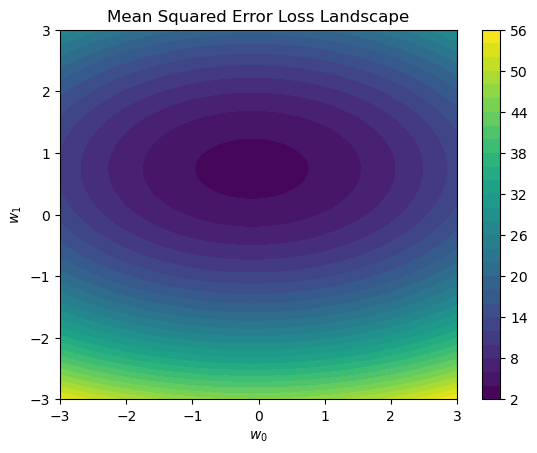

In [86]:
def mse_w(w0, w1):
    pred = w1 * X + w0
    return(np.mean((y_noisy - pred) ** 2))

xy = np.linspace(-3, 3, 100)
z = np.array([[mse_w(i, j) for i in xy] for j in xy])

plt.contourf(xy, xy, z, levels=30)
plt.colorbar()
plt.xlabel(r'$w_0$')
plt.ylabel(r'$w_1$')
plt.title(r'Mean Squared Error Loss Landscape')
plt.show()

Looking at the 2D map, we can say that the MSE is minimized when the parameters ($w_0$ and $w_1$) are both between $0$ and $1$. It seems acceptable because we previously found values of $-0.036$ and $0.687$ when solving the normal equation.

We can tune a bit the value of xy to have a better vizualization of the best parameter's values.

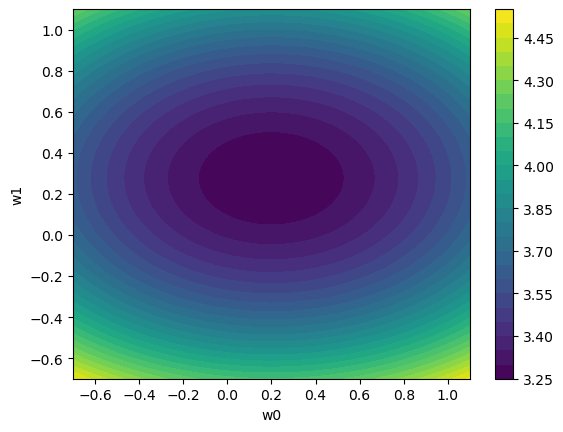

In [87]:
x_t = np.linspace(-.7, .5, 100)
y_t = np.linspace(.2, 1.2, 100)

xy_tuned = np.linspace(-.7, 1.1, 100)
z_tuned = np.array([[mse_w(i, j) for i in x_t] for j in y_t])

plt.contourf(xy_tuned, xy_tuned, z_tuned, levels=30)
plt.colorbar()
plt.xlabel('w0')
plt.ylabel('w1')
plt.show()

# 3. Polynomial linear regression

We move on the polynomial linear regression model with degree $D$, where the relationship between $y_i$ and $x_i$ is
$ y_i = w_0 + w_1x_i + w_2x_i^2 + \ldots + w_D x_i^D $

With $\textbf{w} = [w_0, \ldots, w_D]^T$ and $\textbf{x}_i = [1, x_i, x_i^2, \ldots, x_i^D]^T$, we have $y_i = \textbf{w}^T \textbf{x}_i $.

$D \geq 1$ is an hyperparameter of the model.

**(Question)** Complete the following `PolynomialRegression` class

In [88]:
class PolynomialRegression():
    def __init__(self, D=1):
        assert D >=1
        self.D = D
        
    def fit(self, X, y):
        '''Apply polynomial linear regression to fit `X` to `y`.
        The result should be stored in an attribute `w`.'''
        XTX_inv = np.linalg.inv(np.dot(X.T, X))
        self.w = np.dot(np.dot(XTX_inv, X.T), y)
        
    def predict(self, X):
        '''Assuming the model has already been fit, return
        predicted `y` values for given `X`.'''
        res = np.array([sum([self.w[i] * (x ** i) for i in range(len(self.w))]) for x in X])
        return res

    def make_poly(self, X):
        '''Augment a dataset of 1D points (vector of size N) to its
        data matrix in polynomial form, including the zero column 
        (matrix of size N x D+1). Return the data matrix.'''
        assert X.ndim == 1
        
        augmented_dataset = np.zeros((len(X), self.D + 1))

        for d in range(self.D+1):
            augmented_dataset[:,d] = X ** d

        return augmented_dataset

**(Question)** Implement the mean squared error function to measure the quality of predictions.

In [89]:
def mean_squared_error(y_true, y_pred):
    '''Return the mean squared error between `y_true` and `y_pred`.'''
    assert y_true.shape == y_pred.shape
    return (np.mean((y_true - y_pred) ** 2))

In [90]:
a, b = np.random.randn(10), np.random.randn(10)
assert mean_squared_error(a, b) >= 0.
assert mean_squared_error(a, a) == 0.

**(Question)** Apply the polynomial regression model with $D=5$. Compute and print the mean squared error for the training and validation sets.

In [91]:
model = PolynomialRegression(5)

model.fit(model.make_poly(X_train), y_train)
poly = model.predict(X)

y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

mse_training = mean_squared_error(y_train, y_pred_train)
mse_validation = mean_squared_error(y_valid, y_pred_valid)

print(f"Mean Squared Error on the training set :{mse_training}.")
print(f"Mean Squared Error on the validation set :{mse_validation}.")

Mean Squared Error on the training set :2.2356061439207937.
Mean Squared Error on the validation set :3.3215133873116596.


As expected, the error is lower o the training set because our model has been trained to fit the points in the training set.

**(Question)** Plot the fitted polynomial curve on top of the data points. Explain the result. (complete the code and comment in the cell below)

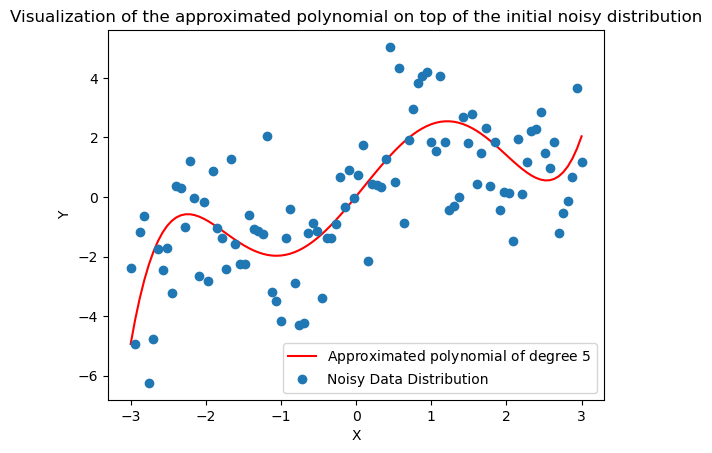

In [92]:
plt.plot(X, poly, 'r', label=r'Approximated polynomial of degree $5$')
plt.plot(X, y_noisy, 'o', label=r'Noisy Data Distribution')
plt.xlabel(r'X')
plt.ylabel(r'Y')
plt.title(r'Visualization of the approximated polynomial on top of the initial noisy distribution')
plt.legend()
plt.show()

* First, we can see that the red curve is of degree 5 (4 inflexion points).

* After that, another observation is that the polymial always stays inside the points, which is satisfiable when searching for a good approximation. But again, we see that the most extreme points are still far of the distribution, which is a clue that a polynomial of degree higher than $5$ will approximate the distribution better.

**(Question)** Using the validation set, implement a simple model selection strategy to optimize hyperparameter $D$ and print this value. For this question, you should limit the search to $D \in [1, 15]$.
To visualize potential underfitting and overfitting effects, plot the evolution of the error on the training and the validation sets for the different values of $D$.

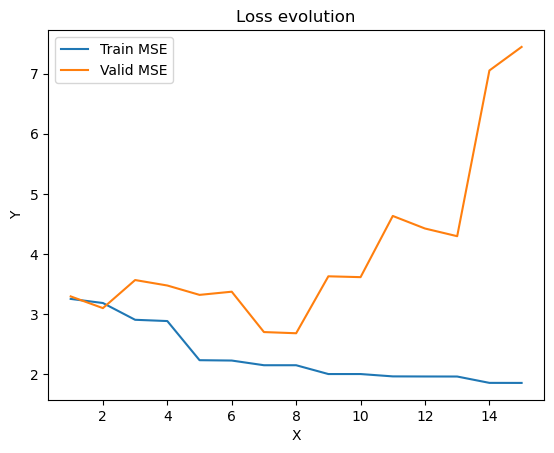

In [93]:
degrees = np.arange(1,16,1)

train_mse = np.zeros(15)
valid_mse = np.zeros(15)

for d in degrees:
    model = PolynomialRegression(d)

    model.fit(model.make_poly(X_train), y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_valid)

    train_mse[d-1] = mean_squared_error(y_train, y_pred_train)
    valid_mse[d-1] = mean_squared_error(y_valid, y_pred_val)

plt.plot(degrees, train_mse, label=r'Train MSE')
plt.plot(degrees, valid_mse, label=r'Valid MSE')
plt.title(r"Loss evolution")
plt.xlabel(r"X")
plt.ylabel(r"Y")
plt.legend()
plt.show()

* We can observe some  underfitting (for degrees $1$ ans $2$). Indeed, the MSE on the validation set is slightly better than the one on the training set, meaning that the model hasn't learn a lot from the training data.

* And then, for a degree greater than $8$, we arrive in overfitting because the training error keeps decreasing while the validation error increases.

* Therefore, we directly know than the optimal degree should be between $3$ and $8$ (and graphically we assume that it should be $8$ which is confirmed in the next cell).

In [94]:
opt_deg = degrees[np.argmin(valid_mse)]
print("Best 'D' value:", opt_deg)

Best 'D' value: 8


**(Question)** Plot the fitted polynomial curve of the best model on top of the data points. Comment the results.

In [95]:
model = PolynomialRegression(5)
model.fit(model.make_poly(X_train), y_train)

best_model = PolynomialRegression(opt_deg)
best_model.fit(best_model.make_poly(X_train), y_train)
best_poly = best_model.predict(X)
best_poly_mse = mean_squared_error(y_valid, best_model.predict(X_valid))

print("MSE (deg 5)", mean_squared_error(y_valid, model.predict(X_valid)))
print("MSE (deg 8)", mean_squared_error(y_valid, best_model.predict(X_valid)))

MSE (deg 5) 3.3215133873116596
MSE (deg 8) 2.6835233478532627


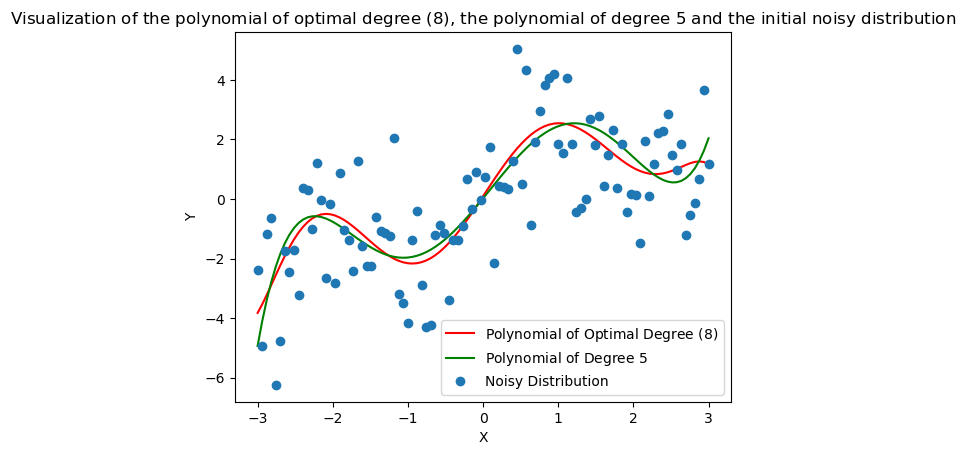

In [96]:
plt.plot(X, best_poly, 'r', label=r'Polynomial of Optimal Degree ($8$)')
plt.plot(X, poly, 'g', label=r'Polynomial of Degree $5$')
plt.plot(X, y_noisy, 'o', label=r'Noisy Distribution')
plt.xlabel(r'X')
plt.ylabel(r'Y')
plt.title(r'Visualization of the polynomial of optimal degree ($8$), the polynomial of degree $5$ and the initial noisy distribution')
plt.legend()
plt.show()

We can observe that the optimal polynomial of degree $8$ does not seem to be much better than the polynomial of degree $5$ while the MSE seemed to be reduced by nearly $0.5$ on the previous plot. It can be explain in different ways:

* A higher-degree polynomial, like the degree $8$ one, can fit small details or noise in the data that lower the MSE, but these details might not be noticeable or important to the overall pattern.

* The degree $8$ polynomial might fit specific points too closely without making the overall fit much better, so it has a lower MSE but doesn't look much better on the plot.

# 4. Regularized polynomial regression

Now, we want to implement polynomial regression with *weight decay* regularization:
$\hat{L}(\textbf{w}) = \frac{1}{N} \lVert \textbf{X} \textbf{w} - \textbf{y} \rVert^2 + \lambda \lVert\textbf{w}\rVert^2$

Here, $\lambda \geq 0$ is another hyperparameter of our model.

**(Question)** Complete the following `RegularizedPolynomialRegression` class.

In [97]:
class RegularizedPolynomialRegression():
    def __init__(self, D=1, lmbda=1.):
        assert D >=1 and lmbda >= 0.
        self.D = D
        self.lmbda = lmbda
        
    def fit(self, X, y):
        '''Apply polynomial linear regression to fit `X` to `y`.
        The result should be stored in an attribute `w`.'''
        XTX_inv = np.linalg.inv(self.lmbda * np.identity(self.D + 1) + np.dot(X.T, X))
        self.w = np.dot(np.dot(XTX_inv, X.T), y)
        
    def predict(self, X):
        '''Assuming the model has already been fit, return
        predicted `y` values for given `X`.'''
        res = np.array([sum([self.w[i] * (x ** i) for i in range(len(self.w))]) for x in X])
        return res

    def make_poly(self, X):
        '''Augment a dataset of 1D points (vector of size N) to its
        data matrix in polynomial form, including the zero column 
        (matrix of size N x D+1). Return the data matrix.'''
        assert X.ndim == 1
        
        augmented_dataset = np.zeros((len(X), self.D + 1))

        for d in range(self.D+1):
            augmented_dataset[:,d] = X ** d

        return augmented_dataset

**(Question)** Apply regularized linear regression and play around with hyperparameters $D$ and $\lambda$. Plot the result.

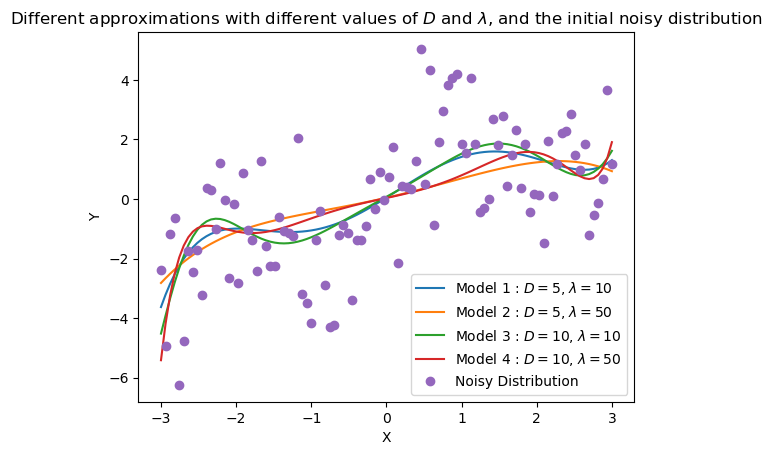

In [98]:
model_ridge1 = RegularizedPolynomialRegression(D=5, lmbda=10)

model_ridge1.fit(model_ridge1.make_poly(X_train), y_train)
poly_ridge1 = model_ridge1.predict(X)

model_ridge2 = RegularizedPolynomialRegression(D=5, lmbda=50)

model_ridge2.fit(model_ridge2.make_poly(X_train), y_train)
poly_ridge2 = model_ridge2.predict(X)

model_ridge3 = RegularizedPolynomialRegression(D=10, lmbda=10)

model_ridge3.fit(model_ridge3.make_poly(X_train), y_train)
poly_ridge3 = model_ridge3.predict(X)

model_ridge4 = RegularizedPolynomialRegression(D=10, lmbda=50)

model_ridge4.fit(model_ridge4.make_poly(X_train), y_train)
poly_ridge4 = model_ridge4.predict(X)

plt.plot(X, poly_ridge1, label=r'Model 1 : $D = 5$, $\lambda = 10$')
plt.plot(X, poly_ridge2, label=r'Model 2 : $D = 5$, $\lambda = 50$')
plt.plot(X, poly_ridge3, label=r'Model 3 : $D = 10$, $\lambda = 10$')
plt.plot(X, poly_ridge4, label=r'Model 4 : $D = 10$, $\lambda = 50$')
plt.plot(X, y_noisy, 'o', label=r'Noisy Distribution')
plt.xlabel(r'X')
plt.ylabel(r'Y')
plt.title(r'Different approximations with different values of $D$ and $\lambda$, and the initial noisy distribution')
plt.legend()
plt.show()

This first plot shows that the variation of $\lambda$ will influence the height of the extrema while the variation of $D$ will simply impact the number of inflection points. But this first view was made with some random values so we will next do a sort of matrix containing $25$ different combinations of parameters to see if their impact is observable (a row contains polynomials build with the same degree while a column keeps the $\lambda$ constant).

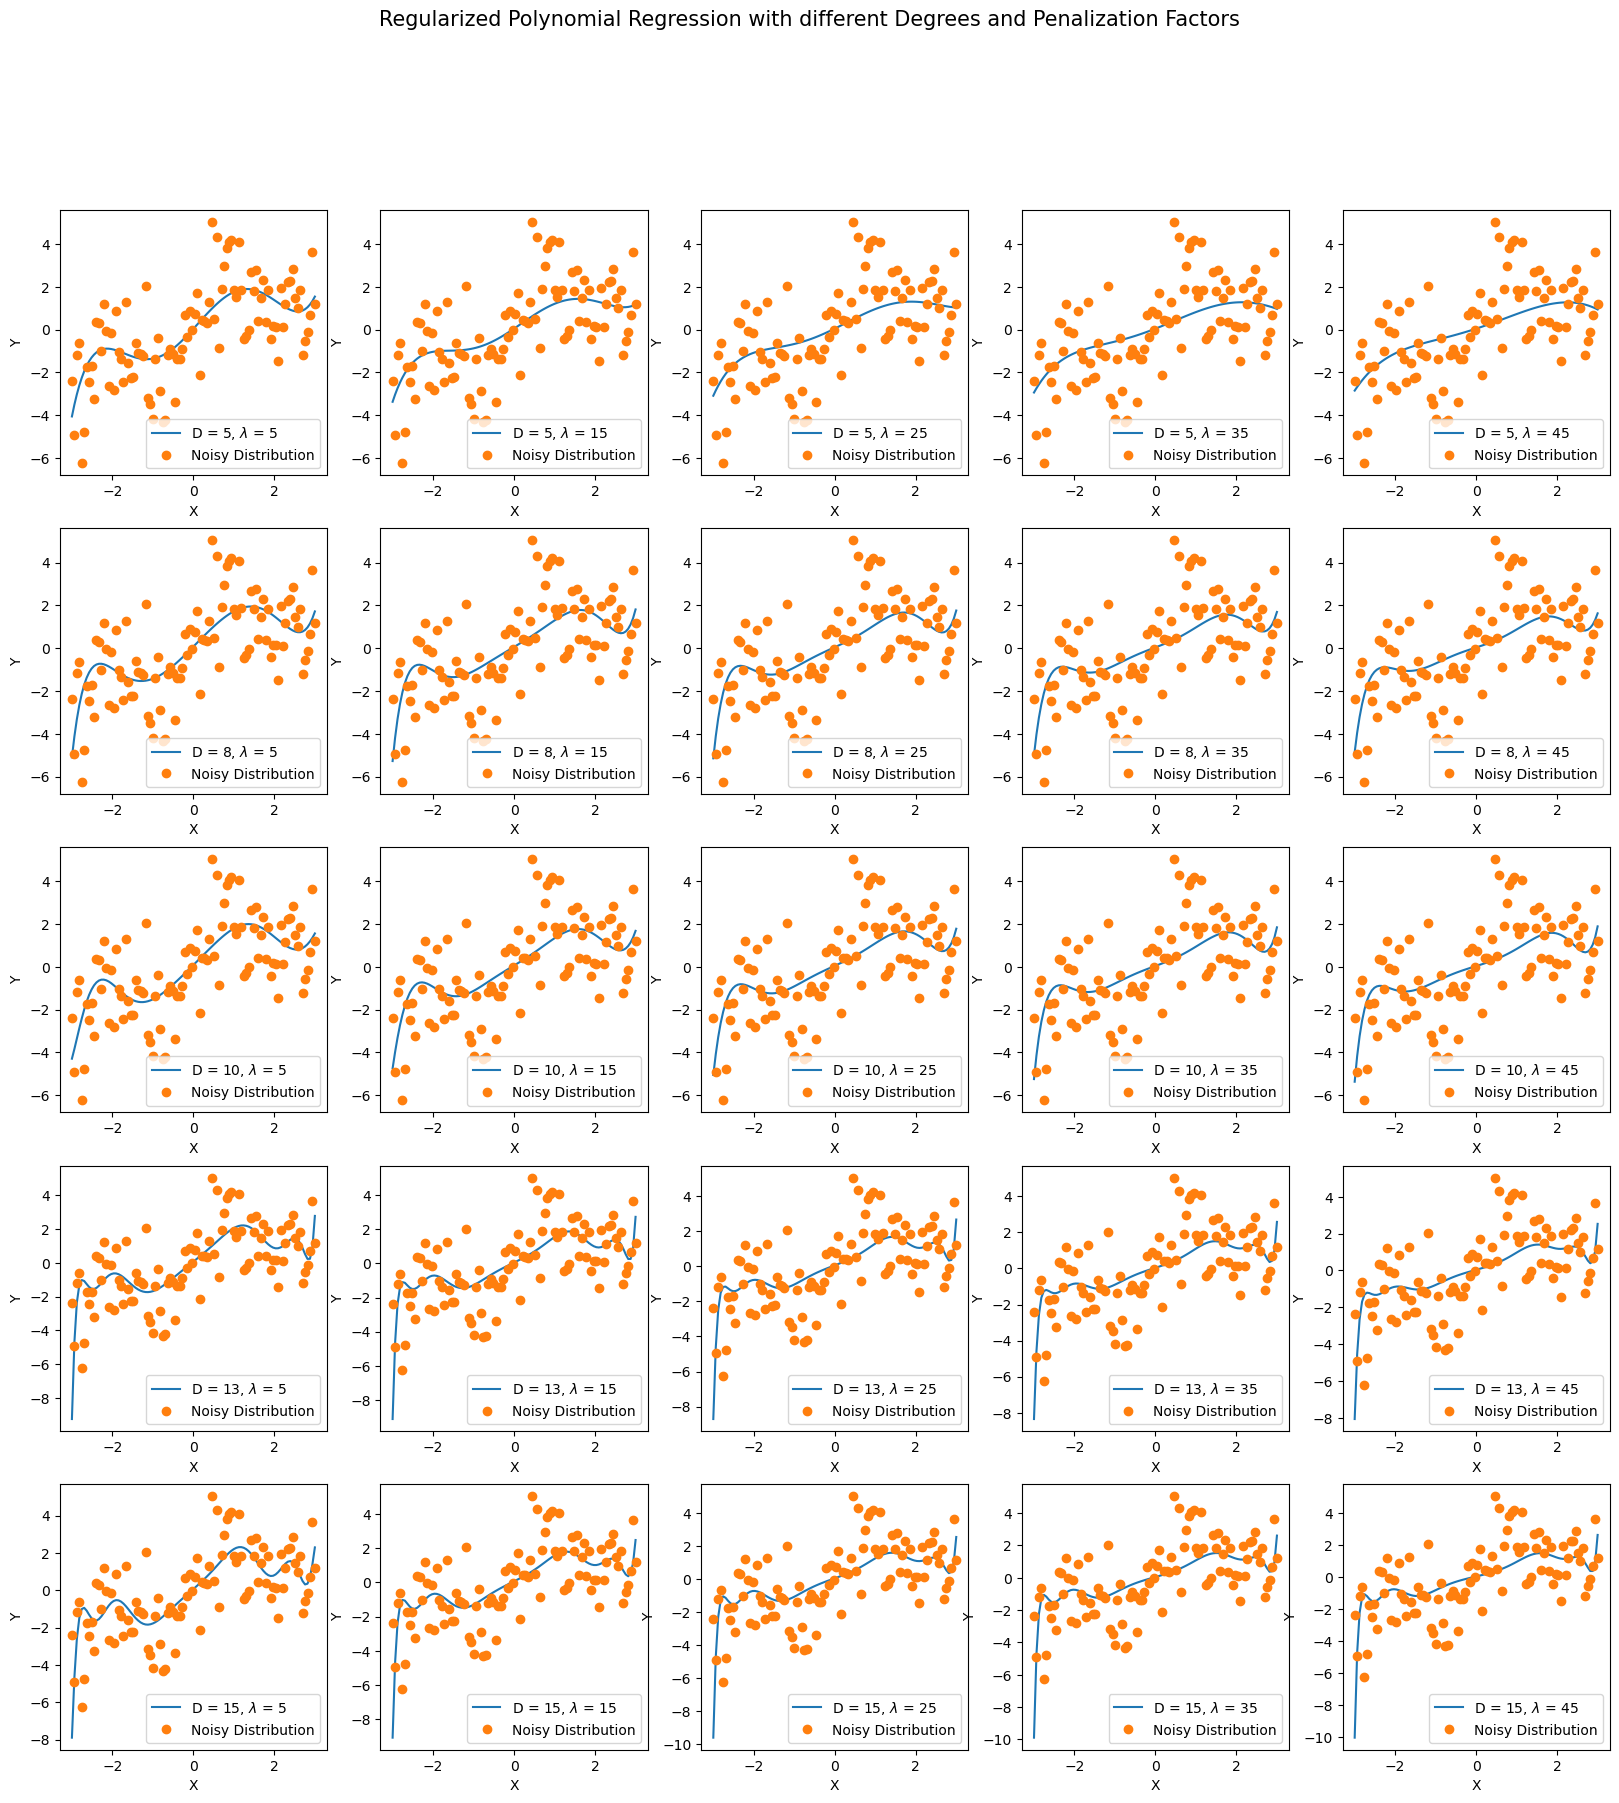

In [99]:
D = [5, 8, 10, 13, 15]
lmbda = [5, 15, 25, 35, 45]

fig, ax = plt.subplots(len(D), len(lmbda), figsize=(20,20))

for i in range(len(D)):
    for j in range(len(lmbda)):
        model = RegularizedPolynomialRegression(D=D[i], lmbda=lmbda[j])
        model.fit(model.make_poly(X_train), y_train)
        poly = model.predict(X)

        ax[i,j].plot(X, poly, label=fr'D = {D[i]}, $\lambda$ = {lmbda[j]}')
        ax[i,j].plot(X, y_noisy, 'o', label=r'Noisy Distribution')
        ax[i,j].set_xlabel(r'X')
        ax[i,j].set_ylabel(r'Y')
        ax[i,j].legend()

fig.suptitle(r'Regularized Polynomial Regression with different Degrees and Penalization Factors', fontsize=15)        
plt.show()   

* As expected, the higher the parameter $\lambda$, the smoother the curve (for example the upper right plot only has $2$ visible inflexion points while on the previous ones, we clearly saw that it had $4$ of them).

* And looking at the variation of degree, we can observe that for a constant $\lambda$, the polynomial becomes more complex as its degree increases.

* Looking at the different combinations, it is not possible to directly conclude and choose which combination of parameters is the best but it is clear that we should pay attention to the tuning of these hyperparameters if we wanted to build the best possible model.

# 5. Comparison with `sklearn`

**(Question)** Use the `sklearn` classes imported above to apply polynomial regression on our toy dataset. Compare the results with your implementation and comment.

MSE (Own implementation linear) = 2.6835233478532627
MSE (Sklearn linear) = 2.6835233478508855
Difference linear = 2.377209540327385e-12

MSE (Own implementation ridge) = 3.533960884532693
MSE (Sklearn ridge) = 3.537357941174561
Difference ridge = 0.003397056641868179


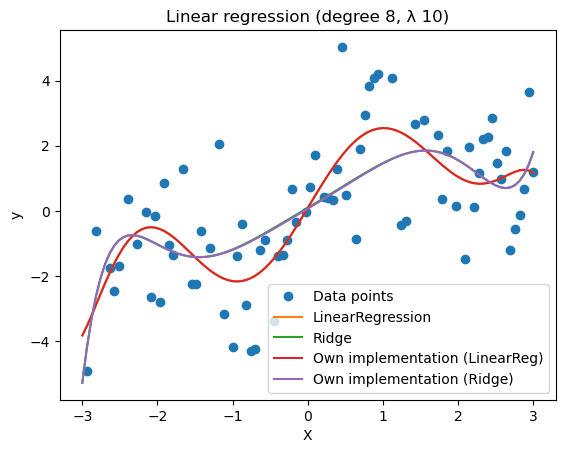

In [100]:
degree = 8

model1 = RegularizedPolynomialRegression(8, 0)
model1.fit(model1.make_poly(X_train), y_train)

model2 = RegularizedPolynomialRegression(8, 10)
model2.fit(model2.make_poly(X_train), y_train)

poly_features = PolynomialFeatures(degree)
X_poly = poly_features.fit_transform(X_train.reshape(-1, 1))

sklearn_model1 = LinearRegression()
sklearn_model1.fit(X_poly, y_train)

sklearn_model2 = Ridge(alpha=10)
sklearn_model2.fit(X_poly, y_train)

X_poly_pred = poly_features.transform(X.reshape(-1, 1))

y_pred1 = sklearn_model1.predict(X_poly_pred)
y_pred2 = sklearn_model2.predict(X_poly_pred)

MSE_own_lin = mean_squared_error(y_valid, model1.predict(X_valid))
MSE_scikit_lin = mean_squared_error(y_valid, sklearn_model1.predict(poly_features.transform(X_valid.reshape(-1, 1))))

MSE_own_ridge = mean_squared_error(y_valid, model2.predict(X_valid))
MSE_scikit_ridge = mean_squared_error(y_valid, sklearn_model2.predict(poly_features.transform(X_valid.reshape(-1, 1))))

print("MSE (Own implementation linear) =", MSE_own_lin)
print("MSE (Sklearn linear) =", MSE_scikit_lin)
print("Difference linear =", abs(MSE_own_lin - MSE_scikit_lin))
print()
print("MSE (Own implementation ridge) =", MSE_own_ridge)
print("MSE (Sklearn ridge) =", MSE_scikit_ridge)
print("Difference ridge =", abs(MSE_own_ridge - MSE_scikit_ridge))

plt.plot(X_train, y_train, 'o', label='Data points')
plt.plot(X, y_pred1, label='LinearRegression')
plt.plot(X, y_pred2, label='Ridge')
plt.plot(X, model1.predict(X), label="Own implementation (LinearReg)")
plt.plot(X, model2.predict(X), label="Own implementation (Ridge)")
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.title(f'Linear regression (degree {degree}, λ 10)')
plt.show()

* Our implementation's graph follows perfectly the sklearn's graph. We get a very small MSE difference ($10^{-12}$ for the linear regression and $10^{-12}$ for the ridge) so we can conclude that our implemention is close to the one build in sklearn.

* To go a bit further, we can take a look at the evolution of the score of our model on both the training and the validation sets. This computed score is called $R^2$ (the coefficient of determination) and is defined as $\frac{\sum (y_{true} - y_{pred})^2}{\sum (y_{true} - mean(y_{true}))^2}$. Physically, it can be seen as the proportion of the total variation in the observed data that is captured by the model. An $R^2$ of $1$ indicates perfect prediction, while an $R^2$ of $0$ means the model explains none of the variance, and all variation is due to noise or unexplained factors.

    In fact, we will be looking at the value of $1 - R^2$ because it can be seen as the proportion of unexplained variance in the model. It's an indication of how much of the variation in the target variable is not captured by the model. The higher $1 - R^2$, the worse the model's fit. Therefore, this measure can be seen as a sort of loss.

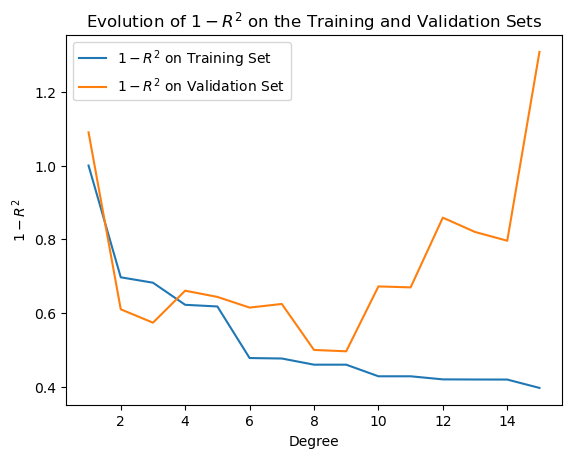

In [101]:
X_transformed = X.reshape(-1, 1)
X_train, X_valid = X_train.reshape(-1, 1), X_valid.reshape(-1, 1)

linReg = LinearRegression()
linReg.fit(X_train, y_train)

y_pred_lin = linReg.predict(X_valid)

training_score = linReg.score(X_train, y_train)
validation_score = linReg.score(X_valid, y_valid)
mse_lin = mean_squared_error(y_valid, y_pred_lin)

def make_poly(X_train, X_valid, y_train, y_valid, degrees):
    training_score = np.zeros(len(degrees))
    validation_score = np.zeros(len(degrees))
    mean_squared_err = np.zeros(len(degrees))
    i = 0

    while(i < len(degrees)):
        poly_features = PolynomialFeatures(degree=i)
        X_train_poly = poly_features.fit_transform(X_train)
        X_valid_poly = poly_features.transform(X_valid)

        polyReg = LinearRegression()
        polyReg.fit(X_train_poly, y_train)

        y_pred_poly = polyReg.predict(X_valid_poly)

        training_score[i] = polyReg.score(X_train_poly, y_train)
        validation_score[i] = polyReg.score(X_valid_poly, y_valid)
        mean_squared_err[i] = mean_squared_error(y_valid, y_pred_poly)

        i += 1

    return training_score, validation_score, mean_squared_err

degrees = np.arange(1,16,1)
train_score_poly, valid_score_poly, mse_poly = make_poly(X_train, X_valid, y_train, y_valid, degrees)

plt.plot(degrees, 1-train_score_poly, label=r'$1 - R^2$ on Training Set')
plt.plot(degrees, 1-valid_score_poly, label=r'$1 - R^2$ on Validation Set')
plt.xlabel(r'Degree')
plt.ylabel(r'$1 - R^2$')
plt.title(r'Evolution of $1 - R^2$ on the Training and Validation Sets')
plt.legend()
plt.show()

* Observing the quantity $1 - R^2$ that has a value greater than $1$ indicates a poor fit, where the model performs worse than simply predicting the mean of the target for all inputs, meaning that we are in overfitting. This can be observed for a degree greater than $13$ but in fact, overfitting has already began sooner, around a degree of $9$, when the validation score begins to increase. This value is again close to the "optimal" degree found with our implementation, renforcing our idea that we implemented a model close to the one build in scikit-learn.

* Finally, we wanted to tune the parameters $\lambda$ in the Ridge Regression for the model train with scikit-learn. This will be done with a GridSearch on a vector going from $0.1$ to $50$ with a step of $0.1$ (this is clearly to precise and not optimal but the dataset is small so it does not take too long, on a larger dataset, a less precise tuning or a one with a RandomSearch should be prefered). This GridSearch will build a model with each possible value of the parameter and perform cross-validation with the same value of the parameter ($5$ cross-validations per model in this implementation). After all these tests, the searh will contains the "best model", based on the score we gave to do the comparison (we choosed the negative mean squared error in this case) and we can obtain the parameter used to build this "optimal model".

    NB: This method is not perfect because we are a bit "cheating" by doing this, indeed, we use the validation set to tune the parameter and therefore, the points are not hidden anymore. In general, it would be better to split the dataset in $3$ : Training; Validation and Test Sets and perform the the tuning on the $2$ first sets while keeping the Test Set hidden but in this case, we do not have lots of data so a 3-sets split would be a bit excessive. 

In [102]:
lambda_tuned = Ridge()

params = {
    'alpha': np.arange(0.1, 50, 0.1),
}

grid_search_ridge = GridSearchCV(estimator=lambda_tuned, param_grid=params, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
grid_search_ridge.fit(X_valid, y_valid)

print("Best Hyperparameters:", grid_search_ridge.best_params_['alpha'])
print("Best MSE:", -grid_search_ridge.best_score_)

Best Hyperparameters: 7.5
Best MSE: 3.5217041501885546


In [103]:
ridgeReg = Ridge(grid_search_ridge.best_params_['alpha'])
ridgeReg.fit(X_train, y_train)

y_pred_ridge = ridgeReg.predict(X_valid)

training_score_ridge = ridgeReg.score(X_train, y_train)
validation_score_ridge = ridgeReg.score(X_valid, y_valid)
mse_ridge_tuned = mean_squared_error(y_valid, y_pred_ridge)

In [104]:
print("MSE (Own implementation ridge) =", MSE_own_ridge)
print("MSE (Sklearn ridge) =", MSE_scikit_ridge)
print("MSE (Sklearn ridge tuned) =", mse_ridge_tuned)
print("Difference ridge random and ridge tuned =", abs(mse_ridge_tuned - MSE_scikit_ridge))

MSE (Own implementation ridge) = 3.533960884532693
MSE (Sklearn ridge) = 3.537357941174561
MSE (Sklearn ridge tuned) = 3.3300143070526427
Difference ridge random and ridge tuned = 0.20734363412191836


Observing these results, we see that hyperparameter tuning can be important if we want to improve our predictions, a gain of $0.207$ in terms of MSE is indeed interesting. 